In [143]:
print("Deprem Risk Projesi başlatıldı ✅")


Deprem Risk Projesi başlatıldı ✅


In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [145]:
df=pd.read_excel("../data/raw/raw_deprem.xlsx")

In [146]:
df.head()

,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName
0,01/04/2025 13:52:35,30.4314,35.9406,24.21,MW,4.1,Akdeniz - [41.71 km] Kumluca (Antalya),656426,AFAD,AFAD,AFAD
1,27/03/2025 17:51:52,25.7344,36.6817,7.00,MW,4.5,Ege Denizi,656087,AFAD,AFAD,AFAD
2,21/03/2025 03:47:26,25.4622,36.6025,7.00,MW,4.2,Ege Denizi,655633,AFAD,AFAD,AFAD
3,20/03/2025 18:33:47,40.6242,39.6608,6.98,MW,4.2,Tercan (Erzincan),655603,AFAD,AFAD,AFAD
4,16/03/2025 15:07:19,24.8008,36.4333,7.00,MW,4.1,Ege Denizi,655339,AFAD,AFAD,AFAD


In [147]:
print(df.columns)

Index(['Date', 'Longitude', 'Latitude', 'Depth', 'Type', 'Magnitude',
       'Location', 'EventID', 'TimeName', 'TypeName', 'MagnitudeName'],
      dtype='object')


In [148]:
print(df.shape)

(16149, 11)


In [149]:
df=df.iloc[:,:7]

In [150]:
print(df.columns)

Index(['Date', 'Longitude', 'Latitude', 'Depth', 'Type', 'Magnitude',
       'Location'],
      dtype='object')


In [151]:
def il_cek(location):
    if "(" in str(location) and ")" in str(location):
        return location.split("(")[-1].replace(")", "").strip()
    return location

df["Il"] = df["Location"].apply(il_cek)

df[["Location", "Il"]].head()


,Location,Il
0,Akdeniz - [41.71 km] Kumluca (Antalya),Antalya
1,Ege Denizi,Ege Denizi
2,Ege Denizi,Ege Denizi
3,Tercan (Erzincan),Erzincan
4,Ege Denizi,Ege Denizi


In [152]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date"])

df["Date"].head()


0   2025-04-01 13:52:35
1   2025-03-27 17:51:52
2   2025-03-21 03:47:26
3   2025-03-20 18:33:47
4   2025-03-16 15:07:19
Name: Date, dtype: datetime64[ns]

In [153]:
df["Magnitude"] = pd.to_numeric(df["Magnitude"], errors="coerce")
df["Depth"] = pd.to_numeric(df["Depth"], errors="coerce")

df = df.dropna(subset=["Magnitude", "Depth"])


In [154]:
analiz_df = df[["Il", "Magnitude", "Depth", "Date"]]
analiz_df.head()


,Il,Magnitude,Depth,Date
0,Antalya,4.1,24.21,2025-04-01 13:52:35
1,Ege Denizi,4.5,7.00,2025-03-27 17:51:52
2,Ege Denizi,4.2,7.00,2025-03-21 03:47:26
3,Erzincan,4.2,6.98,2025-03-20 18:33:47
4,Ege Denizi,4.1,7.00,2025-03-16 15:07:19


In [155]:
# İl bilgisi geçersiz olanları temizle
analiz_df = analiz_df[
    (analiz_df["Il"] != "-") &
    (analiz_df["Il"] != "") &
    (~analiz_df["Il"].str.contains("Denizi", na=False))
]


In [156]:
il_istatistik = analiz_df.groupby("Il").agg(
    deprem_sayisi=("Magnitude", "count"),
    ortalama_buyukluk=("Magnitude", "mean"),
    max_buyukluk=("Magnitude", "max")
).reset_index()

il_istatistik.head()


,Il,deprem_sayisi,ortalama_buyukluk,max_buyukluk
0,Adana,38,4.376316,6.0
1,Adıyaman,83,4.321687,5.5
2,Afyonkarahisar,2,4.400000,4.4
3,Akdeniz,281,4.436655,7.2
4,"Akdeniz , Gazimağusa Körfezi",1,4.600000,4.6


In [157]:
max_deprem = il_istatistik["deprem_sayisi"].max()
max_ortalama = il_istatistik["ortalama_buyukluk"].max()
max_buyukluk = il_istatistik["max_buyukluk"].max()

il_istatistik["risk_skoru"] = (
    (il_istatistik["deprem_sayisi"] / max_deprem) * 4 +
    (il_istatistik["ortalama_buyukluk"] / max_ortalama) * 3 +
    (il_istatistik["max_buyukluk"] / max_buyukluk) * 3
)

il_istatistik.head()


,Il,deprem_sayisi,ortalama_buyukluk,max_buyukluk,risk_skoru
0,Adana,38,4.376316,6.0,4.311833
1,Adıyaman,83,4.321687,5.5,4.489444
2,Afyonkarahisar,2,4.400000,4.4,3.402450
3,Akdeniz,281,4.436655,7.2,6.890390
4,"Akdeniz , Gazimağusa Körfezi",1,4.600000,4.6,3.547683


In [158]:
def risk_seviyesi(skor):
    if skor < 3:
        return "Düşük"
    elif skor < 6:
        return "Orta"
    else:
        return "Yüksek"

il_istatistik["risk_seviyesi"] = il_istatistik["risk_skoru"].apply(risk_seviyesi)
il_istatistik.head()


,Il,deprem_sayisi,ortalama_buyukluk,max_buyukluk,risk_skoru,risk_seviyesi
0,Adana,38,4.376316,6.0,4.311833,Orta
1,Adıyaman,83,4.321687,5.5,4.489444,Orta
2,Afyonkarahisar,2,4.400000,4.4,3.402450,Orta
3,Akdeniz,281,4.436655,7.2,6.890390,Yüksek
4,"Akdeniz , Gazimağusa Körfezi",1,4.600000,4.6,3.547683,Orta


In [159]:
en_riskli_10 = il_istatistik.sort_values(by="risk_skoru", ascending=False).head(10)
en_riskli_10


,Il,deprem_sayisi,ortalama_buyukluk,max_buyukluk,risk_skoru,risk_seviyesi
110,Muğla,463,4.320734,6.5,8.151757,Yüksek
79,Kahramanmaraş,325,4.335385,7.7,7.420937,Yüksek
3,Akdeniz,281,4.436655,7.2,6.890390,Yüksek
35,Datça Açıkları-Ege Dizi,1,7.700000,7.7,5.932690,Orta
104,Malatya,224,4.401786,5.9,5.890693,Orta
61,Gölcük-Kocaeli,1,7.600000,7.6,5.855754,Orta
48,Erzican,3,7.066667,7.9,5.779165,Orta
54,Gerede-Bolu,1,7.300000,7.3,5.624947,Orta
147,Yunanistan,157,4.422930,6.6,5.585920,Orta
75,Ilgaz-Çakırı,1,7.200000,7.2,5.548011,Orta


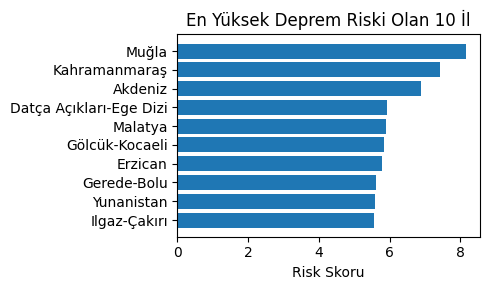

In [160]:
plt.figure(figsize=(5,3))
plt.barh(en_riskli_10["Il"].astype(str), en_riskli_10["risk_skoru"])
plt.xlabel("Risk Skoru")
plt.title("En Yüksek Deprem Riski Olan 10 İl")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [161]:
import folium


In [162]:
harita.save("turkiye_harita.html")
print("Harita kaydedildi ✅")


Harita kaydedildi ✅


In [163]:
# Türkiye sınırları dışında kalan kayıtları temizle
df_harita = df[
    (df["Latitude"] > 35) & (df["Latitude"] < 43) &
    (df["Longitude"] > 25) & (df["Longitude"] < 45)
]

# Haritayı tekrar oluştur
harita = folium.Map(location=[39, 35], zoom_start=6, tiles="cartodbpositron")

for _, row in il_istatistik.iterrows():
    renk = "green"
    if row["risk_seviyesi"] == "Orta":
        renk = "orange"
    elif row["risk_seviyesi"] == "Yüksek":
        renk = "red"

    lat = df_harita[df_harita["Il"] == row["Il"]]["Latitude"].mean()
    lon = df_harita[df_harita["Il"] == row["Il"]]["Longitude"].mean()

    if pd.notnull(lat) and pd.notnull(lon):
        folium.Marker(
            location=[lat, lon],
            popup=f"""
            <b>{row['Il']}</b><br>
            Risk Skoru: {row['risk_skoru']:.2f}<br>
            Seviye: {row['risk_seviyesi']}
            """,
            icon=folium.Icon(color=renk)
        ).add_to(harita)

harita.save("turkiye_risk_haritasi.html")
print("Türkiye odaklı harita hazır ✅")


Türkiye odaklı harita hazır ✅


In [165]:
# Haritayı yeniden oluştur
harita = folium.Map(location=[39, 35], zoom_start=6, tiles="cartodbpositron")

for _, row in il_istatistik.iterrows():
    # Renk seçimi
    renk = "green"
    if row["risk_seviyesi"] == "Orta":
        renk = "orange"
    elif row["risk_seviyesi"] == "Yüksek":
        renk = "red"

    lat = df[df["Il"] == row["Il"]]["Latitude"].mean()
    lon = df[df["Il"] == row["Il"]]["Longitude"].mean()

    folium.Marker(
        location=[lat, lon],
        popup=f"""
        <b>{row['Il']}</b><br>
        Risk Skoru: {row['risk_skoru']:.2f}<br>
        Seviye: {row['risk_seviyesi']}
        """,
        icon=folium.Icon(color=renk)
    ).add_to(harita)

# Haritayı tekrar kaydet
harita.save("turkiye_risk_haritasi.html")
print("Risk haritası hazır ✅")


Risk haritası hazır ✅
